Original implementation of Contrastive-sc method
(https://github.com/ciortanmadalina/contrastive-sc)

In [1]:
import sys
sys.path.append("..")
import argparse
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from sklearn.cluster import KMeans
from sklearn import metrics

import torch
import torch.nn as nn
import copy
from tqdm.notebook import tqdm
import models
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import st_loss

import h5py
import scipy as sp
import scanpy.api as sc
from collections import Counter
import random
import utils
import loop
import pickle

import train
import os
import glob2
plt.ion()
plt.show()
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

/opt/conda/lib/python3.7/site-packages/scanpy/api/__init__.py:7: FutureWarning: 

In a future version of Scanpy, `scanpy.api` will be removed.
Simply use `import scanpy as sc` and `import scanpy.external as sce` instead.

  FutureWarning,


In [2]:
path = "../"
files = glob2.glob(f'{path}real_data/*.h5')
files = [f[len(f"'{path}real_data"):-3] for f in files]
files

['Quake_Smart-seq2_Trachea',
 'Quake_Smart-seq2_Diaphragm',
 'Quake_10x_Spleen',
 'Young',
 '10X_PBMC_select_2100',
 'mouse_ES_cell',
 'Adam',
 'Quake_10x_Bladder',
 'Quake_Smart-seq2_Lung',
 'worm_neuron_cell_select_2100',
 'Quake_10x_Limb_Muscle',
 'worm_neuron_cell',
 'mouse_bladder_cell',
 'mouse_ES_cell_select_2100',
 'Romanov',
 'Quake_Smart-seq2_Limb_Muscle',
 'Muraro',
 'mouse_bladder_cell_select_2100',
 '10X_PBMC']

In [58]:
files = [
#     'Quake_Smart-seq2_Trachea',
#     'Quake_Smart-seq2_Diaphragm',
    'Young',
    '10X_PBMC_select_2100',
    'mouse_ES_cell',
    'Adam',
    'Quake_10x_Bladder',
    'Quake_Smart-seq2_Lung',
    'worm_neuron_cell_select_2100',
    'Quake_10x_Limb_Muscle',
    'worm_neuron_cell',
    'mouse_bladder_cell',
    'mouse_ES_cell_select_2100',
    'Romanov',
    'Quake_Smart-seq2_Limb_Muscle',
    'Muraro',
    'mouse_bladder_cell_select_2100',
    '10X_PBMC',
    'Quake_10x_Spleen',
]

In [59]:
sczi = pd.read_pickle(f"../output/pickle_results/real_data/real_data_sczi.pkl")

In [134]:
df = pd.read_pickle(f"{path}output/pickle_results/real_data/real_data_1model.pkl")

In [135]:
# df =df[df["temperature"]!= 0.008]

In [152]:
# df = pd.DataFrame()

for dataset in files:

    print(f">>>>> Data {dataset}")
    print("SCZI ", sczi[sczi["dataset"] == dataset]["ARI"].mean())
    data_mat = h5py.File(f"{path}real_data/{dataset}.h5", "r")
    X = np.array(data_mat['X'])
    Y = np.array(data_mat['Y'])

    cluster_number = np.unique(Y).shape[0]
    nb_genes = 1500
    data_mat = h5py.File(f"{path}real_data/{dataset}.h5", "r")
    X = np.array(data_mat['X'])
    Y = np.array(data_mat['Y'])

    X = train.preprocess(X, nb_genes=nb_genes)
    for temperature in tqdm([0.07,#0.01,
                             #  0.5,
                            ]):
        for dropout in [ 0.9
#                         0.8, 0.2, 0.5 
                       ]:
            for lr in [1e-5
                       #, 1e-4, 1e-6
                      ]:
                for layers in [
                    [60, 40]
#                     [200, 60, 40]
#                     [200, 100, 30, 30, 30]
#                     [200, 100, 30, 30]
#                     [200, 50, 30, 30]
                    #[40], [50], [100, 10]
                    #[60], [50, 50], [150, 50]
#                     [15], [30]
                   # [100], [200]
#                     [50],[100, 30],  [200, 100, 30],  
                              ]:
                    for run in range(2):
                        torch.manual_seed(run)
                        torch.cuda.manual_seed_all(run)
                        np.random.seed(run)
                        random.seed(run)
                        torch.backends.cudnn.deterministic = True
                        torch.backends.cudnn.benchmark = False
                        dresults = train.run(X,
                                             cluster_number,
                                             dataset,
                                             Y=Y,
                                             nb_epochs=30,
                                             lr=lr,
                                             temperature=temperature,
                                             dropout=dropout,
                                             evaluate=False,
                                             n_ensemble=1,
                                             layers=layers,
                                             save_to=f"{path}output/real_data/{run}/",
                                             save_pred = False)
                        dresults["temperature"] = temperature
                        dresults["dropout"] = dropout
                        dresults["lr"] = lr
                        dresults["layers"] = str(layers)
                        dresults["run"] = run
                        print(f".", end = "")
                        print(f"# {temperature}, {dropout}, {lr}, {layers}", 
                              dresults.get('COMBINED_kmeans_ari', ""),
                              dresults.get('COMBINED_leiden_ari', ""), dresults.get('kmeans_ari_0',""),
                              dresults.get('leiden_ari_0', ""))
                        df = df.append(dresults, ignore_index=True)

                        df.to_pickle(f"{path}output/pickle_results/real_data/real_data_1model.pkl")

>>>>> Data Quake_Smart-seq2_Trachea
SCZI  0.8291128219663276
(1350, 23341) (1350, 23341) keeping 1500 genes


.# 0.07, 0.9, 1e-05, [60, 40]   0.5203736252469471 0.185223235504813
.# 0.07, 0.9, 1e-05, [60, 40]   0.5431377462688824 0.1819195181636625

>>>>> Data Quake_Smart-seq2_Diaphragm
SCZI  0.9596701189611787
(870, 23341) (870, 23341) keeping 1500 genes


.# 0.07, 0.9, 1e-05, [60, 40]   0.9762649454656344 0.46713049139998675
.# 0.07, 0.9, 1e-05, [60, 40]   0.974101462768209 0.5078758712695742

>>>>> Data Young
SCZI  0.6629811886776039
(5685, 33658) (5685, 33658) keeping 1500 genes


.# 0.07, 0.9, 1e-05, [60, 40]   0.6807205703523858 0.5701730549600935
.# 0.07, 0.9, 1e-05, [60, 40]   0.6786810273846207 0.5675811080770206

>>>>> Data mouse_ES_cell
SCZI  0.800376096099337
(2717, 24175) (2717, 24175) keeping 1500 genes


.# 0.07, 0.9, 1e-05, [60, 40]   0.6989640766488893 0.6152727928415068
.# 0.07, 0.9, 1e-05, [60, 40]   0.7015455574236529 0.6427232425699337

>>>>> Data Adam
SCZI  0.8634561030635544
(3660, 23797) (3660, 23797) keeping 1500 genes


.# 0.07, 0.9, 1e-05, [60, 40]   0.6603498274382733 0.5407039514913096
.# 0.07, 0.9, 1e-05, [60, 40]   0.658201092331937 0.5004869598635687

>>>>> Data Quake_10x_Bladder
SCZI  0.983095549108186
(2500, 23341) (2500, 23341) keeping 1500 genes


.# 0.07, 0.9, 1e-05, [60, 40]   0.7563420391513298 0.17115158717431195
.# 0.07, 0.9, 1e-05, [60, 40]   0.7545717662012915 0.16461714211742712

>>>>> Data Quake_Smart-seq2_Lung
SCZI  0.7134055445020913
(1676, 23341) (1676, 23341) keeping 1500 genes


.# 0.07, 0.9, 1e-05, [60, 40]   0.6010450646873715 0.3769609291700726
.# 0.07, 0.9, 1e-05, [60, 40]   0.5904255697192201 0.4773036553217032

>>>>> Data Quake_10x_Limb_Muscle
SCZI  0.9610559204789085
(3909, 23341) (3909, 23341) keeping 1500 genes


.# 0.07, 0.9, 1e-05, [60, 40]   0.8072174247537952 0.44048813186172797
.# 0.07, 0.9, 1e-05, [60, 40]   0.9854972372120675 0.3795336196142518

>>>>> Data worm_neuron_cell
SCZI  0.05077670288621814
(4186, 13488) (4186, 13488) keeping 1500 genes


.# 0.07, 0.9, 1e-05, [60, 40]   0.3671450137210982 0.360732934422958
.# 0.07, 0.9, 1e-05, [60, 40]   0.41283859540287227 0.3479040384194774

>>>>> Data mouse_bladder_cell
SCZI  0.4148792388055975
(2746, 20670) (2746, 20670) keeping 1500 genes


.# 0.07, 0.9, 1e-05, [60, 40]   0.45991574854662404 0.5958699572814183
.# 0.07, 0.9, 1e-05, [60, 40]   0.43407020907116145 0.5678587845328297

>>>>> Data Romanov
SCZI  0.75405351856634
(2881, 21143) (2881, 21143) keeping 1500 genes


.# 0.07, 0.9, 1e-05, [60, 40]   0.6814013207116049 0.4183656545873458
.# 0.07, 0.9, 1e-05, [60, 40]   0.6839707117267042 0.3965025568444238

>>>>> Data Quake_Smart-seq2_Limb_Muscle
SCZI  0.9736759009464299
(1090, 23341) (1090, 23341) keeping 1500 genes


.# 0.07, 0.9, 1e-05, [60, 40]   0.6725551820689375 0.4378452895813866
.# 0.07, 0.9, 1e-05, [60, 40]   0.6846688249005248 0.4051119087481306

>>>>> Data Muraro
SCZI  0.7246271034758398
(2122, 19046) (2122, 19046) keeping 1500 genes


.# 0.07, 0.9, 1e-05, [60, 40]   0.8987427028794729 0.44045638623953587
.# 0.07, 0.9, 1e-05, [60, 40]   0.7103536524415346 0.4517428608894596

>>>>> Data 10X_PBMC
SCZI  0.5845649506030623
(4271, 16653) (4271, 16653) keeping 1500 genes


.# 0.07, 0.9, 1e-05, [60, 40]   0.7682299603322437 0.5321240883963461
.# 0.07, 0.9, 1e-05, [60, 40]   0.7685260167774186 0.5108508456925807

>>>>> Data Quake_10x_Spleen
SCZI  0.909534824400645
(9552, 23341) (9552, 23341) keeping 1500 genes


.# 0.07, 0.9, 1e-05, [60, 40]   0.5079016120607546 0.1490293156786814
.# 0.07, 0.9, 1e-05, [60, 40]   0.5126430065592567 0.15169490171935085



In [153]:
files = [
    'Quake_Smart-seq2_Trachea',
    'Quake_Smart-seq2_Diaphragm',
    'Young',
#     '10X_PBMC_select_2100',
    'mouse_ES_cell',
    'Adam',
    'Quake_10x_Bladder',
    'Quake_Smart-seq2_Lung',
#     'worm_neuron_cell_select_2100',
    'Quake_10x_Limb_Muscle',
    'worm_neuron_cell',
    'mouse_bladder_cell',
#     'mouse_ES_cell_select_2100',
    'Romanov',
    'Quake_Smart-seq2_Limb_Muscle',
    'Muraro',
#     'mouse_bladder_cell_select_2100',
    '10X_PBMC',
    'Quake_10x_Spleen',
]

In [154]:
sczi = pd.read_pickle(f"../output/pickle_results/real_data/real_data_sczi.pkl")
sczi = sczi[sczi["dataset"].isin(files)]
sczi.mean()

ARI       0.745684
NMI       0.777119
sil       0.070277
run       1.000000
time    195.854597
dtype: float64

In [155]:
df = pd.read_pickle(f"../output/pickle_results/real_data/real_data_1model.pkl")
df = df[df["dataset"].isin(files)]
df.groupby(["temperature", "layers", "dropout", "lr"])["kmeans_ari_0"].mean().unstack(["layers", "lr"]).T

temperature                          0.01                                \
dropout                              0.20      0.50      0.80      0.90   
layers                 lr                                                 
[100, 30]              0.000001  0.524274  0.570251  0.674296  0.677789   
                       0.000010  0.524274  0.570251  0.674296  0.677789   
                       0.000100  0.524274  0.570251  0.674296  0.677789   
[100]                  0.000010       NaN       NaN       NaN  0.680657   
[150, 50]              0.000010       NaN       NaN       NaN  0.663639   
[15]                   0.000010       NaN       NaN       NaN  0.689687   
[200, 100, 30, 30]     0.000001  0.451915  0.534844  0.654329  0.643847   
                       0.000010  0.451915  0.534844  0.654329  0.643847   
                       0.000100  0.451915  0.534844  0.654329  0.643847   
[200, 100, 30]         0.000001  0.481480  0.529357  0.661415  0.667104   
                       0.000010  0.481480  0.529357  0.661415  0.667104   
                       0.000100  0.481480  0.529357  0.661415  0.667104   
[200]                  0.000010       NaN       NaN       NaN  0.682787   
[30]                   0.000010       NaN       NaN       NaN  0.712900   
[40]                   0.000010       NaN       NaN       NaN  0.727612   
[50, 50]               0.000010       NaN       NaN       NaN  0.657510   
[50]                   0.000001  0.567312  0.615307  0.698723  0.727378   
                       0.000010  0.567312  0.615307  0.698723  0.727378   
                       0.000100  0.567312  0.615307  0.698723  0.727378   
[60]                   0.000010       NaN       NaN       NaN  0.717785   
[200, 100, 30, 30, 30] 0.000010       NaN       NaN       NaN       NaN   
[200, 40]              0.000010       NaN       NaN       NaN       NaN   
[200, 50, 30, 30]      0.000010       NaN       NaN       NaN       NaN   
[200, 60, 40]          0.000010       NaN       NaN       NaN       NaN   
[60, 40]               0.000010       NaN       NaN       NaN       NaN   

temperature                          0.07                                \
dropout                              0.20      0.50      0.80      0.90   
layers                 lr                                                 
[100, 30]              0.000001  0.264483  0.477184  0.629684  0.681896   
                       0.000010  0.264483  0.477184  0.629684  0.681896   
                       0.000100  0.264483  0.477184  0.629684  0.681896   
[100]                  0.000010       NaN       NaN       NaN       NaN   
[150, 50]              0.000010       NaN       NaN       NaN       NaN   
[15]                   0.000010       NaN       NaN       NaN       NaN   
[200, 100, 30, 30]     0.000001  0.204349  0.404540  0.652421  0.692540   
                       0.000010  0.204349  0.404540  0.652421  0.693108   
                       0.000100  0.204349  0.404540  0.652421  0.692540   
[200, 100, 30]         0.000001  0.215987  0.417108  0.646977  0.669458   
                       0.000010  0.215987  0.417108  0.646977  0.669458   
                       0.000100  0.215987  0.417108  0.646977  0.669458   
[200]                  0.000010       NaN       NaN       NaN       NaN   
[30]                   0.000010       NaN       NaN       NaN       NaN   
[40]                   0.000010       NaN       NaN       NaN       NaN   
[50, 50]               0.000010       NaN       NaN       NaN       NaN   
[50]                   0.000001  0.296180  0.496578  0.608322  0.674843   
                       0.000010  0.296180  0.496578  0.608322  0.674843   
                       0.000100  0.296180  0.496578  0.608322  0.674843   
[60]                   0.000010       NaN       NaN       NaN       NaN   
[200, 100, 30, 30, 30] 0.000010       NaN       NaN       NaN  0.677926   
[200, 40]              0.000010       NaN       NaN       NaN  0.689996   
[200, 50, 30, 30]      0

In [156]:
# df = pd.read_pickle(f"../output/pickle_results/real_data/real_data_1model.pkl")
df.groupby(["temperature", "layers", "dropout", "lr"])["kmeans_ari_0"].mean().unstack(["layers", "lr"]).max()

layers                  lr      
[100, 30]               0.000001    0.681896
                        0.000010    0.681896
                        0.000100    0.681896
[100]                   0.000010    0.680657
[150, 50]               0.000010    0.663639
[15]                    0.000010    0.689687
[200, 100, 30, 30]      0.000001    0.692540
                        0.000010    0.693108
                        0.000100    0.692540
[200, 100, 30]          0.000001    0.669458
                        0.000010    0.669458
                        0.000100    0.669458
[200]                   0.000010    0.682787
[30]                    0.000010    0.712900
[40]                    0.000010    0.727612
[50, 50]                0.000010    0.657510
[50]                    0.000001    0.727378
                        0.000010    0.727378
                        0.000100    0.727378
[60]                    0.000010    0.717785
[200, 100, 30, 30, 30]  0.000010    0.677926
[200, 40]             

In [146]:
# r = df[(df["layers"]=="[40]")
#        &(df["temperature"]==0.01)
#        &(df["lr"]==1e-5)
#        &(df["dropout"]==0.9)
#       ]
r = df[(df["layers"]=="[200, 100, 30, 30]")
       &(df["temperature"]==0.07)
       &(df["lr"]==1e-5)
       &(df["dropout"]==0.9)
      ]


r.mean()

dropout         0.900000
kmeans_ari_0    0.693108
kmeans_nmi_0    0.755896
leiden_ari_0    0.283322
leiden_nmi_0    0.596367
lr              0.000010
run             0.800000
temperature     0.070000
time                 NaN
dtype: float64

In [127]:
comb = pd.merge(r, sczi, on=["dataset", "run"])[[
    "dataset", "kmeans_ari_0", "ARI", "kmeans_nmi_0", "NMI"
]].rename(columns = {"kmeans_ari_0": "contrative-sc", "ARI": "sczi"})
comb

,dataset,contrative-sc,sczi,kmeans_nmi_0,NMI
0,Quake_Smart-seq2_Trachea,0.515871,0.826206,0.607704,0.73851
1,Quake_Smart-seq2_Trachea,0.500860,0.826206,0.593372,0.73851
2,Quake_Smart-seq2_Trachea,0.526177,0.845888,0.594374,0.73748
3,Quake_Smart-seq2_Trachea,0.518294,0.845888,0.626403,0.73748
4,Quake_Smart-seq2_Diaphragm,0.960758,0.961073,0.916762,0.93895
...,...,...,...,...,...
70,Romanov,0.670400,0.741953,0.702789,0.72576
71,Quake_Smart-seq2_Limb_Muscle,0.978044,0.970449,0.955893,0.94661
72,Muraro,0.876243,0.646664,0.845930,0.75219
73,10X_PBMC,0.758829,0.671588,0.760859,0.73350


In [128]:
comb =pd.melt(comb, id_vars=["dataset"], value_vars=["contrative-sc", "sczi"])

In [129]:
comb.head()

,dataset,variable,value
0,Quake_Smart-seq2_Trachea,contrative-sc,0.515871
1,Quake_Smart-seq2_Trachea,contrative-sc,0.500860
2,Quake_Smart-seq2_Trachea,contrative-sc,0.526177
3,Quake_Smart-seq2_Trachea,contrative-sc,0.518294
4,Quake_Smart-seq2_Diaphragm,contrative-sc,0.960758


In [130]:
import seaborn as sns

(array([0, 1]), <a list of 2 Text xticklabel objects>)

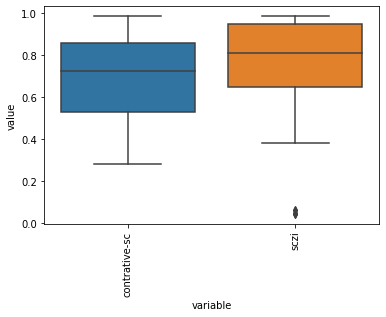

In [131]:
sns.boxplot( data = comb, y="value", x = "variable")
plt.xticks(rotation = 90)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 <a list of 15 Text xticklabel objects>)

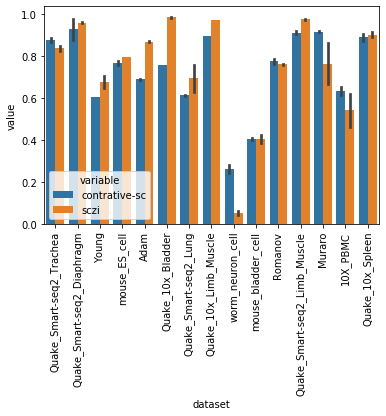

In [114]:
sns.barplot(x = "dataset", data = comb, y="value", hue = "variable")
plt.xticks(rotation = 90)

In [ ]:
df.groupby("dataset").mean()

# Importance of input size

In [ ]:
df = pd.DataFrame(
    columns=["dataset", "perc0", "nb_genes", "exp", "ari", "run"])
print(df.shape)
for dataset in files:

    print(f">>>>> Data {dataset}")

    data_mat = h5py.File(f"{path}real_data/{dataset}.h5", "r")
    for run in range(2):
        torch.manual_seed(run)
        torch.cuda.manual_seed_all(run)
        np.random.seed(run)
        random.seed(run)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        for nb_genes in [100, 200, 500, 1000, 1500, 2000, 5000, 8000]:

            X = np.array(data_mat['X'])
            Y = np.array(data_mat['Y'])
            perc_0 = np.where(X == 0)[0].shape[0] / (X.shape[0] * X.shape[1])
            print(f"Perc 0 {perc_0}")
            cluster_number = np.unique(Y).shape[0]

            X = train.preprocess(X, nb_genes=nb_genes)
            nb_zeros = int(0.8 * nb_genes)
            dresults = train.train(
                X,
                cluster_number,
                dataset,
                Y,
                n_ensemble=1,
                epochs=100,
                nb_zeros=nb_zeros,
                save_to=f"{path}output/real_data/inputs/{dataset}_{nb_genes}/")

            #         df.loc[df.shape[0]] = [
            #                 dataset, perc_0, nb_genes, 'kmeans_representation_0',dresults['kmeans_representation_0']
            #             ]
            df.loc[df.shape[0]] = [
                dataset, perc_0, nb_genes, 'leiden_representation_0',
                dresults['leiden_representation_0'], run]

#             pxt = PCA(2).fit_transform(X)
#             dresults["original"] = utils.evaluate(X, Y, cluster_number)[1]
#             dresults["pca"] = utils.evaluate(pxt, Y, cluster_number)[1]
            print(dresults)
    df.to_pickle(f"{path}output/pickle_results/real_data_input_size.pkl")

In [ ]:
df = pd.read_pickle(f"{path}output/pickle_results/real_data_input_size.pkl")

In [ ]:
df.groupby(["nb_genes"]).mean()

In [ ]:
dataset_names = {
    '10X_PBMC': '10X PBMC',
    '10X_PBMC_select_2100': '10X PBMC (2100)',
    'mouse_ES_cell': 'Mouse ES\nCell',
    'mouse_ES_cell_select_2100': 'Mouse ES\nCell (2100)',
    'worm_neuron_cell_select_2100': 'Worm Neuron\nCell (2100)',
    'worm_neuron_cell': 'Worm Neuron\nCell',
    'mouse_bladder_cell': 'Mouse Bladder\nCell',
    'mouse_bladder_cell_select_2100': 'Mouse Bladder\n Cell (2100)'
}

df["dataset"] = df["dataset"].apply(lambda x: dataset_names[x])

df = df.rename(columns = {"nb_genes": "Nb input genes"})

In [ ]:
df["dataset"].unique()


In [ ]:
import seaborn as sns
datasets = ['10X PBMC',  'Mouse ES\nCell','Worm Neuron\nCell', 'Mouse Bladder\nCell']
plt.figure(figsize=(10, 3.3))
ax = plt.subplot(111)
sns.barplot(
    hue="Nb input genes",
    y="ari",
    x="dataset",
    data=df[df["dataset"].isin(datasets)],
    ax=ax,
    edgecolor='black',
    linewidth=1.5,
)
plt.ylabel("ARI")
plt.xlabel("")
plt.legend(title= "Nb input genes",bbox_to_anchor=(1, 1))
sns.despine()
plt.tight_layout()

plt.savefig(f"{path}diagrams/real_input_size.pdf", bbox_inches='tight')

In [ ]:
datasets = ['10X PBMC (2100)',
       'Mouse ES\nCell (2100)', 'Worm Neuron\nCell (2100)',
       'Mouse Bladder\n Cell (2100)']
plt.figure(figsize=(10, 3.3))
ax = plt.subplot(111)
sns.barplot(
    hue="Nb input genes",
    y="ari",
    x="dataset",
    data=df[df["dataset"].isin(datasets)],
    ax=ax,
    edgecolor='black',
    linewidth=1.5,
)
plt.ylabel("ARI")
plt.xlabel("")
plt.legend(title= "Nb input genes",bbox_to_anchor=(1, 1))
sns.despine()
plt.tight_layout()

plt.savefig(f"{path}diagrams/real_input_size_2100.pdf", bbox_inches='tight')

# Importance of the number of epochs

In [ ]:
df = pd.DataFrame(
    columns=["dataset", "perc0", "nb_epochs", "exp", "ari", "run"])
print(df.shape)
for dataset in files:

    print(f">>>>> Data {dataset}")

    data_mat = h5py.File(f"{path}real_data/{dataset}.h5", "r")
    nb_genes = 1500
    for epochs in [5, 50, 100, 300]:

        X = np.array(data_mat['X'])
        Y = np.array(data_mat['Y'])
        perc_0 = np.where(X == 0)[0].shape[0] / (X.shape[0] * X.shape[1])
        print(f"Perc 0 {perc_0}")
        cluster_number = np.unique(Y).shape[0]

        X = train.preprocess(X, nb_genes=nb_genes)
        nb_zeros = int(0.8 * nb_genes)
        for run in range(2):
            torch.manual_seed(run)
            torch.cuda.manual_seed_all(run)
            np.random.seed(run)
            random.seed(run)
            torch.backends.cudnn.deterministic = True
            torch.backends.cudnn.benchmark = False

            dresults = train.train(
                X,
                cluster_number,
                dataset,
                Y,
                n_ensemble=1,
                epochs=epochs,
                nb_zeros=nb_zeros,
                save_to=f"{path}output/real_data/epochs/{dataset}_{epochs}/")

            df.loc[df.shape[0]] = [
                dataset, perc_0, epochs, 'kmeans_representation_0',
                dresults['kmeans_representation_0'], run
            ]
            df.loc[df.shape[0]] = [
                dataset, perc_0, epochs, 'leiden_representation_0',
                dresults['leiden_representation_0'], run
            ]

            print(dresults)
            df.to_pickle(f"{path}output/pickle_results/real_data_epochs.pkl")

In [ ]:
df = pd.read_pickle(f"{path}output/pickle_results/real_data_epochs.pkl")

In [ ]:
dataset_names = {
    '10X_PBMC': '10X PBMC',
    '10X_PBMC_select_2100': '10X PBMC (2100)',
    'mouse_ES_cell': 'Mouse ES\nCell',
    'mouse_ES_cell_select_2100': 'Mouse ES\nCell (2100)',
    'worm_neuron_cell_select_2100': 'Worm Neuron\nCell (2100)',
    'worm_neuron_cell': 'Worm Neuron\nCell',
    'mouse_bladder_cell': 'Mouse Bladder\nCell',
    'mouse_bladder_cell_select_2100': 'Mouse Bladder\n Cell (2100)'
}

df["dataset"] = df["dataset"].apply(lambda x: dataset_names[x])

df = df.rename(columns = {"nb_epochs": "Nb epochs"})

In [ ]:
import seaborn as sns
datasets = ['10X PBMC',  'Mouse ES\nCell','Worm Neuron\nCell', 'Mouse Bladder\nCell']
plt.figure(figsize=(7, 3))
ax = plt.subplot(111)
sns.barplot(
    hue="Nb epochs",
    y="ari",
    x="dataset",
    data=df[df["dataset"].isin(datasets)],
    ax=ax,
    edgecolor='black',
    linewidth=1.5,
)
plt.ylabel("ARI")
plt.xlabel("")
plt.legend(title ="Number of epochs",bbox_to_anchor=(1, 1))
sns.despine()
plt.tight_layout()

plt.savefig(f"{path}diagrams/real_nb_epochs.pdf", bbox_inches='tight')